# Einasto Profiles

This notebook demonstrates the Einasto halo profile calculations available in the `halox` library. We'll explore the key properties and methods of the `EinastoHalo` class and related functions.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from halox import cosmology
from halox.halo import einasto

jax.config.update("jax_enable_x64", True)

plt.style.use(["seaborn-v0_8-darkgrid", "petroff10"])
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

/Users/lamoreau/halox/.venv/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


## Setting up the Cosmology

First, let's create a cosmology object using the Planck 2018 parameters provided by halox:

In [2]:
# Create a Planck 2018 cosmology
cosmo = cosmology.Planck18()
print(f"Hubble parameter h = {cosmo.h}")
print(f"Matter density Ω_m = {cosmo.Omega_m}")
print(f"Baryon density Ω_b = {cosmo.Omega_b}")
print(f"Cold dark matter density Ω_c = {cosmo.Omega_c}")
print(f"Power spectrum normalization σ_8 = {cosmo.sigma8}")

Hubble parameter h = 0.6766
Matter density Ω_m = 0.30964
Baryon density Ω_b = 0.04897
Cold dark matter density Ω_c = 0.26067
Power spectrum normalization σ_8 = 0.8102


## Creating an Einasto Halo

Now let's create an Einasto halo with specific mass, concentration, alpha, and redshift parameters:

In [3]:
# Halo parameters
m_200 = 1e14  # Mass in h^-1 M_sun
c_200 = 10.0  # Concentration parameter
z = 0.0  # Redshift
alpha = 0.17 # Einasto index, determines rate at which density profile falls off
delta = 200.0  # Overdensity relative to critical density

# Create the NFW halo
halo = einasto.EinastoHalo(m_200, c_200, z, alpha, cosmo, delta=delta)

print(f"Halo mass M_200 = {halo.m_delta:.2e} h^-1 M_sun")
print(f"Concentration c_200 = {halo.c_delta}")
print(f"Virial radius R_200 = {halo.r_delta:.3f} h^-1 Mpc")
print(f"Scale radius R_s = {halo.Rs:.3f} h^-1 Mpc")
print(f"Characteristic density ρ_0 = {halo.rho0:.2e} h^2 M_sun Mpc^-3")

Halo mass M_200 = 1.00e+14 h^-1 M_sun
Concentration c_200 = 10.0
Virial radius R_200 = 0.755 h^-1 Mpc
Scale radius R_s = 0.075 h^-1 Mpc
Characteristic density ρ_0 = 2.89e+15 h^2 M_sun Mpc^-3


## Density Profile

The Einasto density profile is given by:

$$\rho(r) = \rho_s \times \exp{\left[\frac{-2}{\alpha}\left(\frac{r}{r_s}\right)^\alpha -1\right]}$$

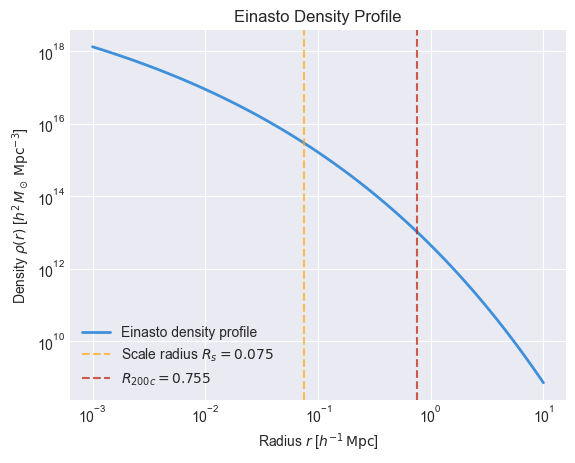

In [4]:
# Create radial grid
r = jnp.logspace(-3, 1, 100)  # From 0.001 to 10 h^-1 Mpc

# Compute density profile
rho = halo.density(r)

# Plot
fig, ax = plt.subplots()
ax.loglog(r, rho, linewidth=2, label="Einasto density profile")
ax.axvline(
    halo.Rs,
    color="C1",
    linestyle="--",
    alpha=0.7,
    label=f"Scale radius $R_s = {halo.Rs:.3f}$",
)
ax.axvline(
    halo.r_delta,
    color="C2",
    linestyle="--",
    alpha=0.7,
    label=f"$R_{{200c}} = {halo.r_delta:.3f}$",
)
ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax.set_title("Einasto Density Profile")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Enclosed Mass Profile

The enclosed mass within radius $r$ is:

$$M(<r) = 4\pi \rho_0 R_s^3 \left[\ln\left(1 + \frac{r}{R_s}\right) - \frac{r}{r + R_s}\right]$$

M(<R_200c) = 1.00e+14 h^-1 M_sun
M_200c = 1.00e+14 h^-1 M_sun


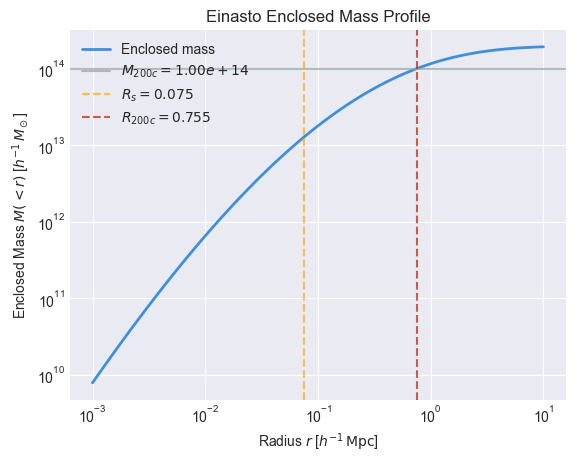

In [5]:
# Compute enclosed mass profile
m_enc = halo.enclosed_mass(r)

# Plot
fig, ax = plt.subplots()
ax.loglog(r, m_enc, linewidth=2, label="Enclosed mass")
ax.axhline(
    halo.m_delta,
    color="C3",
    linestyle="-",
    alpha=0.7,
    label=f"$M_{{200c}} = {halo.m_delta:.2e}$",
)
ax.axvline(
    halo.Rs,
    color="C1",
    linestyle="--",
    alpha=0.7,
    label=f"$R_s = {halo.Rs:.3f}$",
)
ax.axvline(
    halo.r_delta,
    color="C2",
    linestyle="--",
    alpha=0.7,
    label=f"$R_{{200c}} = {halo.r_delta:.3f}$",
)
ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Enclosed Mass $M(<r)$ [$h^{-1} \, M_\odot$]")
ax.set_title("Einasto Enclosed Mass Profile")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

# Verify that M(<R_200) = M_200
m_at_r200 = halo.enclosed_mass(halo.r_delta)
print(f"M(<R_200c) = {m_at_r200:.2e} h^-1 M_sun")
print(f"M_200c = {halo.m_delta:.2e} h^-1 M_sun")

## Gravitational Potential

The gravitational potential is:

$\phi(r) =
-4 \pi G \, \rho_{-2} \, e^{2/\alpha} \left(\frac{\alpha}{2}\right)^{\frac{2}{\alpha}}\frac{R_s^2}{\alpha}\,
\left[
\frac{1}{s} \gamma\!\left(\frac{3}{\alpha}, x\right)
+
\Gamma\left(\frac{2}{\alpha}, x\right)
\right]$

with dimensionless variables
$
s \equiv \left(\frac{2}{\alpha}\right)^{1/\alpha} \frac{r}{R_s}, 
\qquad
x \equiv s^\alpha.
$

See Retana-Montenegra et al. (2012) for more information on how this function is derived.
https://ui.adsabs.harvard.edu/abs/2012A%26A...540A..70R/abstract

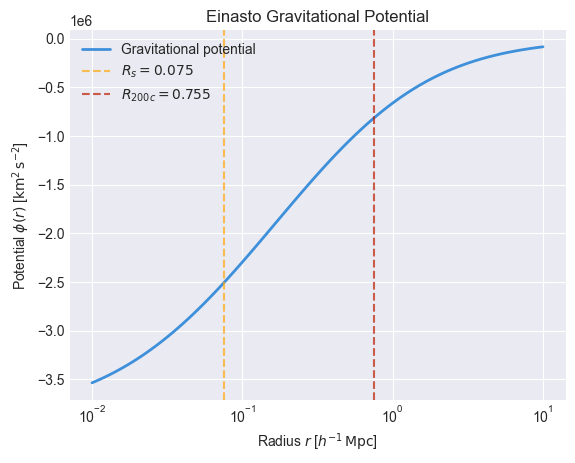

In [27]:
# Compute potential profile (excluding very small radii to avoid divergence)
r_pot = jnp.logspace(-2, 1, 100)  # From 0.01 to 10 h^-1 Mpc
phi = halo.potential(r_pot)

# Plot
fig, ax = plt.subplots()
ax.semilogx(r_pot, phi, linewidth=2, label="Gravitational potential")
ax.axvline(
    halo.Rs,
    color="C1",
    linestyle="--",
    alpha=0.7,
    label=f"$R_s = {halo.Rs:.3f}$",
)
ax.axvline(
    halo.r_delta,
    color="C2",
    linestyle="--",
    alpha=0.7,
    label=f"$R_{{200c}} = {halo.r_delta:.3f}$",
)
ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Potential $\phi(r)$ [${{\rm km}}^2 \, {\rm s}^{-2}$]")
ax.set_title("Einasto Gravitational Potential")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Circular Velocity Profile

The circular velocity is related to the enclosed mass by:

$$v_c(r) = \sqrt{\frac{GM(<r)}{r}}$$

Circular velocity at R_s = 854.0 km/s
Circular velocity at R_200c = 754.8 km/s


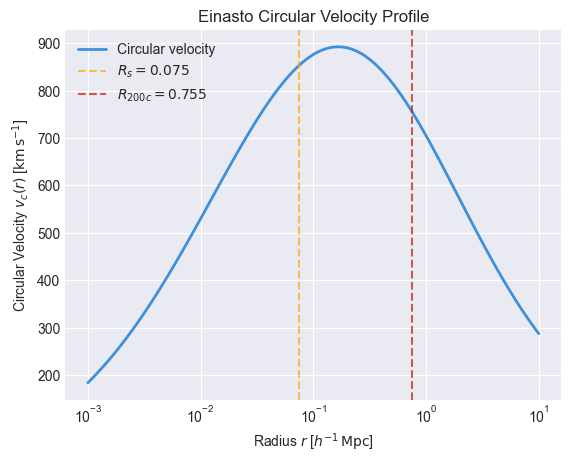

In [7]:
# Compute circular velocity profile
v_c = halo.circular_velocity(r)

# Plot
fig, ax = plt.subplots()
ax.semilogx(r, v_c, linewidth=2, label="Circular velocity")
ax.axvline(
    halo.Rs,
    color="C1",
    linestyle="--",
    alpha=0.7,
    label=f"$R_s = {halo.Rs:.3f}$",
)
ax.axvline(
    halo.r_delta,
    color="C2",
    linestyle="--",
    alpha=0.7,
    label=f"$R_{{200c}} = {halo.r_delta:.3f}$",
)
ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Circular Velocity $v_c(r)$ [${{\rm km}} \, {\rm s}^{-1}$]")
ax.set_title("Einasto Circular Velocity Profile")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

# Print some characteristic values
v_c_at_rs = halo.circular_velocity(halo.Rs)
v_c_at_r200 = halo.circular_velocity(halo.r_delta)
print(f"Circular velocity at R_s = {v_c_at_rs:.1f} km/s")
print(f"Circular velocity at R_200c = {v_c_at_r200:.1f} km/s")

## Converting overdensity definition

`halox` allows you to convert between different SO mass definitions assuming an NFW profile:

In [8]:
print(
    f"Delta = {halo.delta:.0f}c:",
    f"M_Delta = {halo.m_delta:.4e},",
    f"R_Delta = {halo.r_delta:.4f},",
    f"c_Delta = {halo.c_delta:.4f}",
)

M500c, R500c, c500c = halo.to_delta(500.0)

print(
    "Delta = 500c:",
    f"M_Delta = {M500c:.4e},",
    f"R_Delta = {R500c:.4f},",
    f"c_Delta = {c500c:.4f}",
)

Delta = 200c: M_Delta = 1.0000e+14, R_Delta = 0.7548, c_Delta = 10.0000
Delta = 500c: M_Delta = 7.9636e+13, R_Delta = 0.5155, c_Delta = 6.8295


## Vectorization

The `EinastoHalo` class supports vectorized operations, allowing you to work with multiple halos simultaneously:

In [9]:
def rho(r, m, c, z, alpha, cosmo=cosmo, delta=200.0):
    return einasto.EinastoHalo(m_200, c_200, z, alpha, cosmo, delta=delta).density(r)


# Create multiple halos with different masses and concentrations
masses = jnp.array([1e13, 1e14, 1e15])  # h-1 M_sun
concentrations = jnp.array([12.0, 10.0, 8.0])
redshifts = jnp.array([0.5, 0.2, 0.1])
alphas = jnp.array([0.15, 0.17, 0.20])
radii = jnp.logspace(-3, 1, 64)  # h-1 Mpc

rhos = jax.vmap(rho, in_axes=[None, 0, 0, 0, 0, None, None])(
    radii, masses, concentrations, redshifts, alphas, cosmo, delta
)

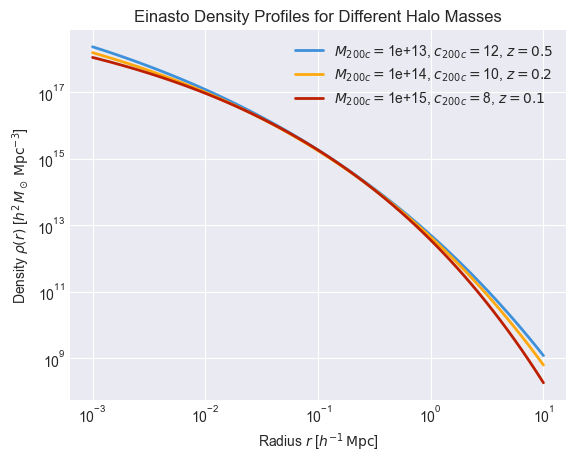

In [10]:
# Plot density profiles for all halos
fig, ax = plt.subplots()

for i in range(len(masses)):
    ax.loglog(
        radii,
        rhos[i],
        lw=2,
        label="$M_{200c}=$"
        + f"{masses[i]:.0e}, "
        + "$c_{200c}=$"
        + f"{concentrations[i]:.0f}, "
        + f"$z={redshifts[i]:.1f}$",
    )

ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax.set_title("Einasto Density Profiles for Different Halo Masses")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Different overdensities

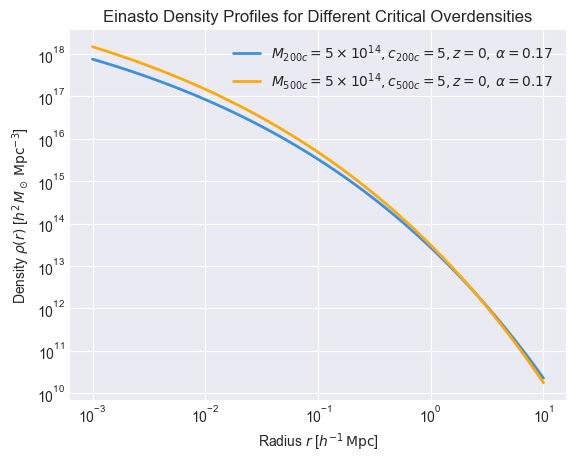

In [11]:
fig, ax = plt.subplots()
r = jnp.logspace(-3, 1, 64)

for delta in [200.0, 500.0]:
    rho = einasto.EinastoHalo(5e14, 5.0, 0.0, 0.17, cosmo=cosmo, delta=delta).density(r)
    d = f"{delta:.0f}c"
    ax.loglog(
        r,
        rho,
        lw=2,
        label=f"$M_{{{d}}}=5 \\times 10^{{14}}, c_{{{d}}}=5, z=0,\,$" + r"$\alpha = 0.17$",
    )

ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax.set_title("Einasto Density Profiles for Different Critical Overdensities")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Acceleration

In [12]:
cosmo = cosmology.Planck18()


def rho(r, m, c, z, alpha, cosmo=cosmo, delta=200.0):
    return einasto.EinastoHalo(m_200, c_200, z, alpha, cosmo, delta=delta).density(r)


rs = jnp.logspace(-3, 1, 64)

Not compiling the function:

In [13]:
%timeit _ = rho(rs, 1e14, 5.0, 0.0, 0.17)

1.68 ms ± 22.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Compiling the function and executing it once to get rid of compilation overhead:

In [14]:
rho_j = jax.jit(rho)
_ = rho_j(rs, 1e14, 5.0, 0.0, 0.17)
%timeit _ = rho_j(rs, 1e14, 5.0, 0.0, 0.17)

17.5 μs ± 69.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
